# fore-/background ED vs CR:
vergleiche back und foreground gene:
- rechne CPM ( Gesamtzahl der Reads im Foregorund und für jedes einzelne Gen teilst du den Wert durch die Gesamtzahl der Reads und multiplizierst mit einer Million)

In [48]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

soup = True

# Load color scheme from JSON file
colorcodes_path = '/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/colorcodes.json'
with open(colorcodes_path, 'r') as f:
    colorcodes = json.load(f)

# Create a gene-to-color mapping from the marker genes
GENE_COLORS = {}
for cell_population, info in colorcodes['marker_genes'].items():
    hex_color = info['hex']
    for gene in info['genes']:
        # If a gene appears in multiple populations, use the first one found
        # (elongated_spermatids has priority in the JSON structure)
        if gene not in GENE_COLORS:
            GENE_COLORS[gene] = hex_color

print(f"Loaded color scheme from: {colorcodes_path}")
print(f"Mapped {len(GENE_COLORS)} marker genes to their cell population colors")

print(f"NumPy version: {np.__version__}")  # Should show 1.26.4

if soup:
    ED_foreground = sc.read_h5ad("../data/pyED_correct_soupx.h5ad")
else:
    ED_foreground = sc.read_h5ad("../data/pyED_correct.h5ad")

CR_foreground = sc.read_10x_h5("../data/filtered_feature_bc_matrix.h5")
adata = sc.read_10x_h5("../data/raw_feature_bc_matrix.h5")

if soup: 
    # soup is missing 3 genes double genes
    CR_foreground.var_names_make_unique()
    adata.var_names_make_unique()

    # soup is missing 3 genes so remove the missing ones from CR_foreground and adata
    CR_foreground = CR_foreground[:, CR_foreground.var_names.isin(ED_foreground.var_names)]
    adata = adata[:, adata.var_names.isin(ED_foreground.var_names)]
    

# print shapes
print(adata.shape)
print(ED_foreground.shape)
print(CR_foreground.shape)

Loaded color scheme from: /Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/colorcodes.json
Mapped 54 marker genes to their cell population colors
NumPy version: 2.0.2


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(722431, 22037)
(8202, 22037)
(2701, 22037)


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## generate Background

In [49]:
# calculate background out of adata-foreground -> all cells that are not in foreground
ED_background = adata[~adata.obs_names.isin(ED_foreground.obs_names)]
print(ED_background.shape)
CR_background = adata[~adata.obs_names.isin(CR_foreground.obs_names)]
print(CR_background.shape)

(714229, 22037)
(719730, 22037)


## calculate CPM

In [50]:
import warnings

#remove cells that have 0 counts in all genes
#foreground = foreground[foreground.X.sum(axis=1) > 0]
#background = background[background.X.sum(axis=1) > 0]

# suppress warnings (got some duplicate and empty cell warnings)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # make unique
    ED_foreground.var_names_make_unique()
    ED_background.var_names_make_unique()
    CR_foreground.var_names_make_unique()
    CR_background.var_names_make_unique()

    print(ED_foreground.X[:1,:40])

    # calculate CPM
    ED_foreground_norm = sc.pp.normalize_total(ED_foreground, target_sum=1e6, inplace=False)["X"]
    ED_background_norm = sc.pp.normalize_total(ED_background, target_sum=1e6, inplace=False)["X"]
    CR_foreground_norm = sc.pp.normalize_total(CR_foreground, target_sum=1e6, inplace=False)["X"]
    CR_background_norm = sc.pp.normalize_total(CR_background, target_sum=1e6, inplace=False)["X"]
    print("done")
    print(ED_foreground[:1,:40])

  (np.int32(0), np.int32(1))	0.0
  (np.int32(0), np.int32(15))	1.381116517925074
  (np.int32(0), np.int32(20))	0.8780046788137152
  (np.int32(0), np.int32(25))	0.8658131658633851
  (np.int32(0), np.int32(27))	0.8703431259456917
  (np.int32(0), np.int32(28))	1.7471522218433129
  (np.int32(0), np.int32(30))	2.8125040548775555
  (np.int32(0), np.int32(31))	0.79420399180009
done
View of AnnData object with n_obs × n_vars = 1 × 40
    uns: 'X_name'


## calculate log2fc

In [51]:
# Calculate fold change ratios for each gene (comparing gene expression levels by using mean gene expression)
# Fold change = foreground_CPM / background_CPM
# log2fc = log2(fold change)

# np mean always crashes the kernel no matter what version (e.g. 1.2 vs 2.0) i am using
# so instead of using arrays and np i will use scanpy sparse mean calculation

print(ED_foreground_norm.shape)
print(ED_background_norm.shape)

print("\nCALC MEAN")
ED_foreground_mean = ED_foreground_norm.mean(axis=0)
ED_background_mean = ED_background_norm.mean(axis=0)
CR_foreground_mean = CR_foreground_norm.mean(axis=0)
CR_background_mean = CR_background_norm.mean(axis=0)
print(ED_foreground_mean[0])
print(ED_foreground_mean.shape)

print("\nADD PSEUDOCOUNT")
pseudocnt = 1e-6
ED_foreground_mean = ED_foreground_mean + pseudocnt
ED_background_mean = ED_background_mean + pseudocnt
CR_foreground_mean = CR_foreground_mean + pseudocnt
CR_background_mean = CR_background_mean + pseudocnt
print(ED_foreground_mean[0])
print(ED_foreground_mean.shape)

print("\nCALC FoldChange")
ED_fc = (ED_foreground_mean) / (ED_background_mean )
CR_fc = (CR_foreground_mean) / (CR_background_mean )
print(ED_fc[0])
print(ED_fc.shape)


print("\nCALC LOG2FoldChange")
ED_log2fc = np.log2(ED_fc)
CR_log2fc = np.log2(CR_fc)
print(ED_log2fc[:5])
print(ED_log2fc.shape)

(8202, 22037)
(714229, 22037)

CALC MEAN
[[   2.15002381 1153.81191094   53.35178281 ...   15.3357511
    40.58671894  160.50201631]]
(1, 22037)

ADD PSEUDOCOUNT
[[   2.15002481 1153.81191194   53.35178381 ...   15.3357521
    40.58671994  160.50201731]]
(1, 22037)

CALC FoldChange
[[5.21746085e-02 3.73319145e+01 1.34753994e+01 ... 1.04505529e+00
  2.39882936e-02 1.60502018e+08]]
(1, 22037)

CALC LOG2FoldChange
[[-4.26050832  5.22233759  3.75225612 ...  0.06357928 -5.38152565
  27.25801619]]
(1, 22037)


In [52]:
stats_data = {
    'EmptyDrops': {
        'Shape': str(ED_log2fc.shape),
        'Mean': ED_log2fc.mean(),
        'Std': ED_log2fc.std(),
        'Max': ED_log2fc.max(),
        'Min': ED_log2fc.min()
    },
    'CellRanger': {
        'Shape': str(CR_log2fc.shape),
        'Mean': CR_log2fc.mean(),
        'Std': CR_log2fc.std(),
        'Max': CR_log2fc.max(),
        'Min': CR_log2fc.min()
    }
}

# Create DataFrame with ED and CR as columns
stats_df = pd.DataFrame(stats_data)

print("\nNORMAL DISTRIBUTION CHECK - on log2fc")
print(stats_df)


NORMAL DISTRIBUTION CHECK - on log2fc
       EmptyDrops  CellRanger
Shape  (1, 22037)  (1, 22037)
Mean     2.019058    0.970905
Std     11.884238    3.697129
Max      30.63898   20.678783
Min    -32.001791  -21.145977


# print out the top 20 genes that have a high log2fc in ED_log2fc

In [53]:
# Get top 20 genes with highest log2fc in EmptyDrops
# First, flatten the array to handle matrix format and filter out invalid values
ED_log2fc_flat = np.asarray(ED_log2fc).flatten()
valid_mask = np.isfinite(ED_log2fc_flat)  # Remove inf and nan values
valid_indices = np.where(valid_mask)[0]
valid_log2fc = ED_log2fc_flat[valid_mask]

# Get top genes from valid values, excluding ENSSSCG genes
if len(valid_log2fc) > 0:
    # Sort all valid indices by log2fc in descending order
    sorted_valid_indices = np.argsort(valid_log2fc)[::-1]
    sorted_original_indices = valid_indices[sorted_valid_indices]
    sorted_log2fc = valid_log2fc[sorted_valid_indices]
    
    # Filter out genes starting with "ENSSSCG" and get top 20
    top_genes = []
    top_log2fc = []
    enssscg_filtered_count = 0
    
    for idx, log2fc in zip(sorted_original_indices, sorted_log2fc):
        gene_name = ED_foreground.var_names[idx]
        if gene_name.startswith("ENSSSCG"):
            enssscg_filtered_count += 1
        else:
            top_genes.append(gene_name)
            top_log2fc.append(log2fc)
            if len(top_genes) == 20:
                break

    print(f"Filtered out {enssscg_filtered_count} ENSSSCG genes from top candidates")
    print("Top 20 genes with highest log2(FoldChange) in EmptyDrops (excluding ENSSSCG genes):")
    print("-" * 70)
    for i, (gene, log2fc) in enumerate(zip(top_genes, top_log2fc), 1):
        print(f"{i:2d}. {gene:<15} log2fc: {log2fc:.3f}")
else:
    print("No valid log2fc values found")


# save top_genes and top_log2fc
if soup:
    with open("ED_log2fc_top_genes_soup.txt", "w") as f:
        f.write("Gene \t log2fc\n")
        for gene, log2fc in zip(top_genes, top_log2fc):
            f.write(f"{gene}\t{log2fc}\n")

else:
    with open("ED_log2fc_top_genes.txt", "w") as f:
        f.write("Gene \t log2fc\n")
        for gene, log2fc in zip(top_genes, top_log2fc):
            f.write(f"{gene}\t{log2fc}\n")

Filtered out 7 ENSSSCG genes from top candidates
Top 20 genes with highest log2(FoldChange) in EmptyDrops (excluding ENSSSCG genes):
----------------------------------------------------------------------
 1. TMSB10          log2fc: 30.639
 2. RPL37           log2fc: 30.528
 3. COX7A2          log2fc: 30.116
 4. RBMS3           log2fc: 30.080
 5. RPL35           log2fc: 29.951
 6. LRBA            log2fc: 29.951
 7. ND3             log2fc: 29.722
 8. AUTS2           log2fc: 29.671
 9. PRKN            log2fc: 29.623
10. RPS5            log2fc: 29.527
11. EIF1            log2fc: 29.488
12. ZFAND3          log2fc: 29.414
13. CALM3           log2fc: 29.339
14. BSDC1           log2fc: 29.325
15. NFIA            log2fc: 29.230
16. EXT1            log2fc: 29.227
17. RPS4X           log2fc: 29.192
18. EBF1            log2fc: 29.164
19. PPP3CA          log2fc: 29.068
20. TMSB4X          log2fc: 29.028


## plot log2fc differences

In [54]:
# reshape to 1D array
np.array(ED_log2fc).flatten().shape

(22037,)

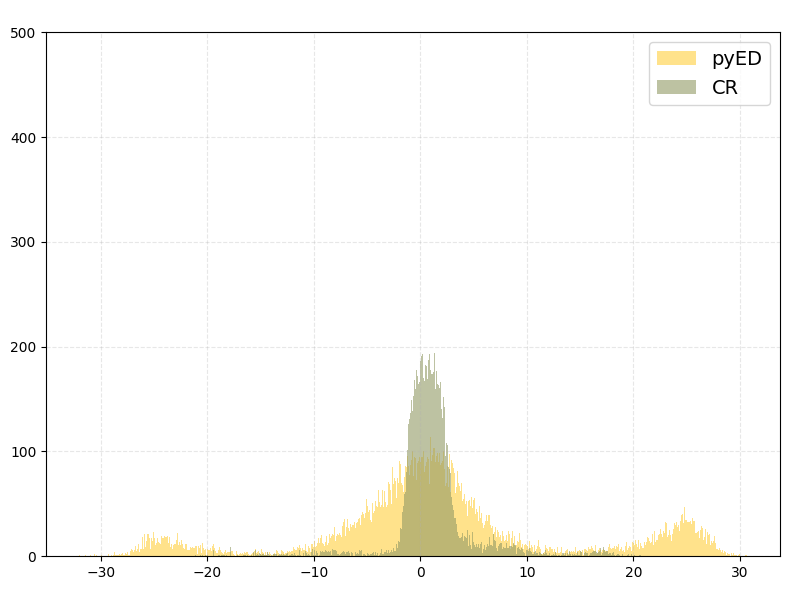

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

# Only plot the right plot with ylim as a single plot
ax.hist(np.array(ED_log2fc).flatten(), bins=1000, alpha=0.6, label="pyED", color="#FFCF3E")
ax.hist(np.array(CR_log2fc).flatten(), bins=1000, alpha=0.6, label="CR", color="#929a65")
ax.legend(fontsize=14)
ax.set_ylim(0, 500)
ax.set_title(" ")
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()

plt.show()

if soup:
    fig.savefig("log2fc_distribution_soup.pdf")
else:
    fig.savefig("log2fc_distribution.pdf")

In [56]:
from scipy.stats import pearsonr
r, _ = pearsonr(np.array(CR_log2fc).flatten(), np.array(ED_log2fc).flatten())
print("Correlation:", r)
print("Korrelation r > 0.8 spricht für ähnliche Verteilungen/Muster zwischen CR und ED. Niedrige Korrelation spricht für systematische Abweichungen in ED (Da es hier die extremwerte hat)")

Correlation: 0.17314211112045524
Korrelation r > 0.8 spricht für ähnliche Verteilungen/Muster zwischen CR und ED. Niedrige Korrelation spricht für systematische Abweichungen in ED (Da es hier die extremwerte hat)


## MA-Plots

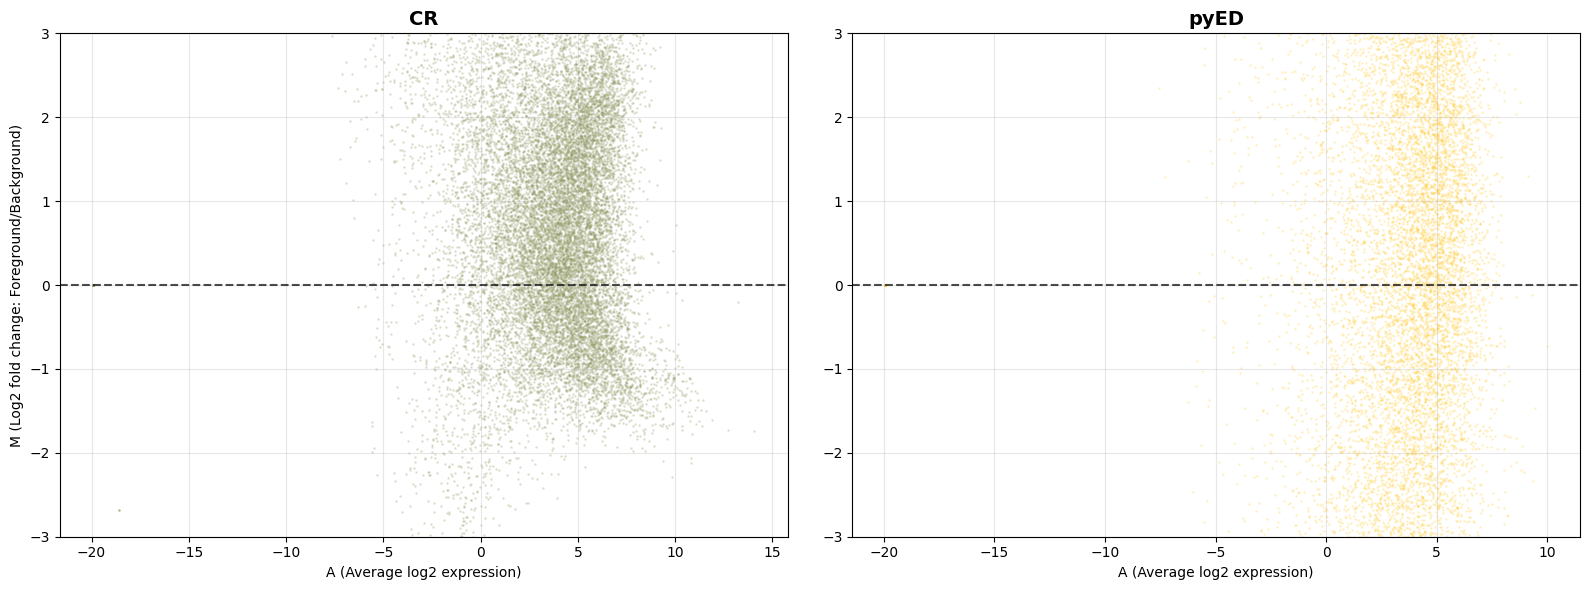

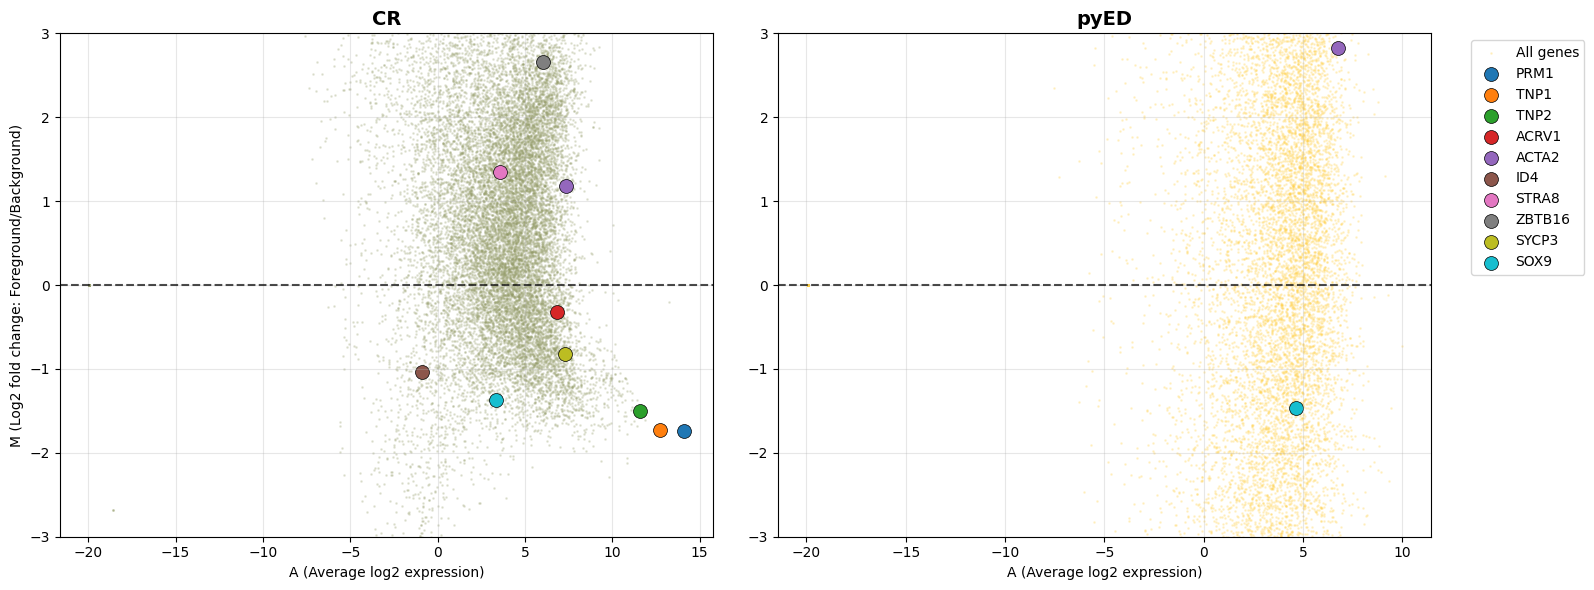

In [57]:
genes_of_interest = ['PRM1', 'TNP1', 'TNP2', 'ACRV1', 'ACTA2', 'ID4', 'STRA8', 'ZBTB16', 'SYCP3', 'SOX9']

def ma_plots(cut=0, genes_of_interest_bool=False):
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # CR MA Plot (now on the left)
    A_CR = (np.log2(CR_foreground_mean) + np.log2(CR_background_mean)) / 2  # Average expression
    M_CR = CR_log2fc  # Log2 fold change

    A_CR_flat = np.asarray(A_CR).flatten()
    M_CR_flat = np.asarray(M_CR).flatten()
    ax.scatter(A_CR_flat, M_CR_flat, alpha=0.2, s=1, color='#929a65', label='All genes')

    if genes_of_interest_bool:
        for gene in genes_of_interest:
            if gene in CR_foreground.var_names:
                gene_idx = CR_foreground.var_names.get_loc(gene)
                # Let matplotlib assign colors if not specified
                ax.scatter(A_CR_flat[gene_idx], M_CR_flat[gene_idx], 
                        s=100, alpha=1, edgecolors='black', linewidth=0.5, label=gene)
                #ax.annotate(gene, (A_CR_flat[gene_idx], M_CR_flat[gene_idx]), 
                #            xytext=(5, 5), textcoords='offset points', 
                #            fontsize=8, weight='bold')

    ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel('A (Average log2 expression)')
    ax.set_ylabel('M (Log2 fold change: Foreground/Background)')
    ax.set_title('CR', size=14, weight='bold')
    ax.grid(True, alpha=0.3)
    
    cut = 3

    if cut > 0:
        ax.set_ylim(-cut, cut)

    # EmptyDrops MA plot (now on the right)
    A_ED = (np.log2(ED_foreground_mean) + np.log2(ED_background_mean)) / 2  # Average expression
    M_ED = ED_log2fc

    A_ED_flat = np.asarray(A_ED).flatten()
    M_ED_flat = np.asarray(M_ED).flatten()
    ax2.scatter(A_ED_flat, M_ED_flat, alpha=0.2, s=1, color='#FFCF3E', label='All genes')

    if genes_of_interest_bool:
        for gene in genes_of_interest:
            if gene in ED_foreground.var_names:
                gene_idx = ED_foreground.var_names.get_loc(gene)
                # No color specified here; matplotlib will assign default/distinct colors
                ax2.scatter(A_ED_flat[gene_idx], M_ED_flat[gene_idx], 
                        s=100, alpha=1, edgecolors='black', linewidth=0.5, label=gene)
                #ax2.annotate(gene, (A_ED_flat[gene_idx], M_ED_flat[gene_idx]), 
                #            xytext=(5, 5), textcoords='offset points', 
                #            fontsize=8, weight='bold')

    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    ax2.set_xlabel('A (Average log2 expression)')
    ax2.set_ylabel(' ')
    ax2.set_title('pyED', size=14, weight='bold')
    ax2.grid(True, alpha=0.3)
    
    if genes_of_interest_bool:
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if cut > 0:
        ax2.set_ylim(-cut, cut)

    plt.tight_layout()
    plt.show()

    if genes_of_interest_bool:
        if soup:
            fig.savefig("MA_plot_highlight_genes_soup.pdf")
        else:
            fig.savefig("MA_plot_highlight_genes.pdf")
    else:
        if soup:
            fig.savefig("MA_plot_soup.pdf")
        else:
            fig.savefig("MA_plot.pdf")


ma_plots()

ma_plots(cut=0, genes_of_interest_bool=True)

## MA-Plots Celltype ?

In [58]:
# empty

## Log2fc ratio

     gene            ED        CR     log2ED    log2CR
0    PRM1  6.743851e+03  0.299110  12.719357 -1.741252
1    TNP1  1.162130e+04  0.302269  13.504484 -1.726095
2    TNP2  1.278061e+06  0.352108  20.285525 -1.505910
3   ACRV1  2.000229e-02  0.803357  -5.643691 -0.315887
4   ACTA2  7.063496e+00  2.260890   2.820382  1.176891
5     ID4  3.204528e-02  0.487595  -4.963744 -1.036244
6   STRA8  5.003084e+01  2.540395   5.644746  1.345053
7  ZBTB16  1.284913e+08  6.303275  26.937096  2.656102
8   SYCP3  9.894749e+00  0.564170   3.306663 -0.825797
9    SOX9  3.612076e-01  0.386059  -1.469100 -1.373105


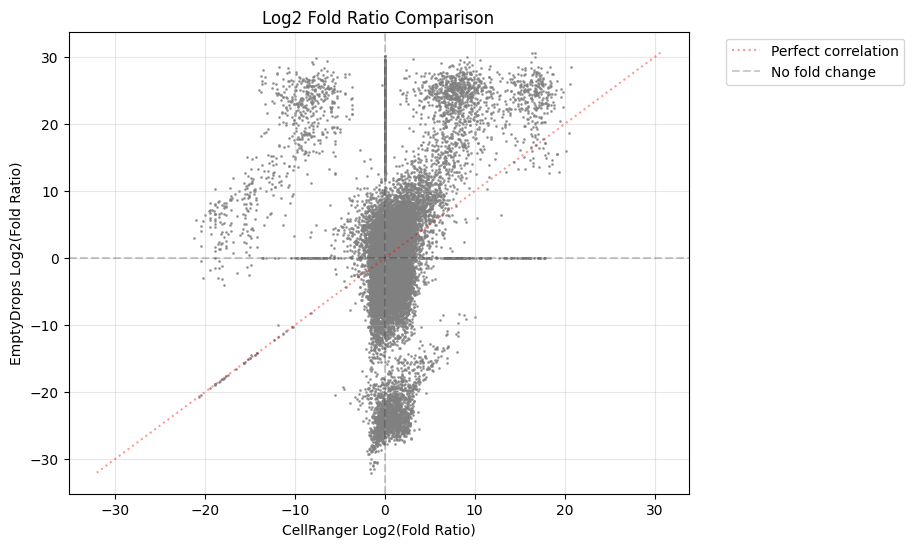

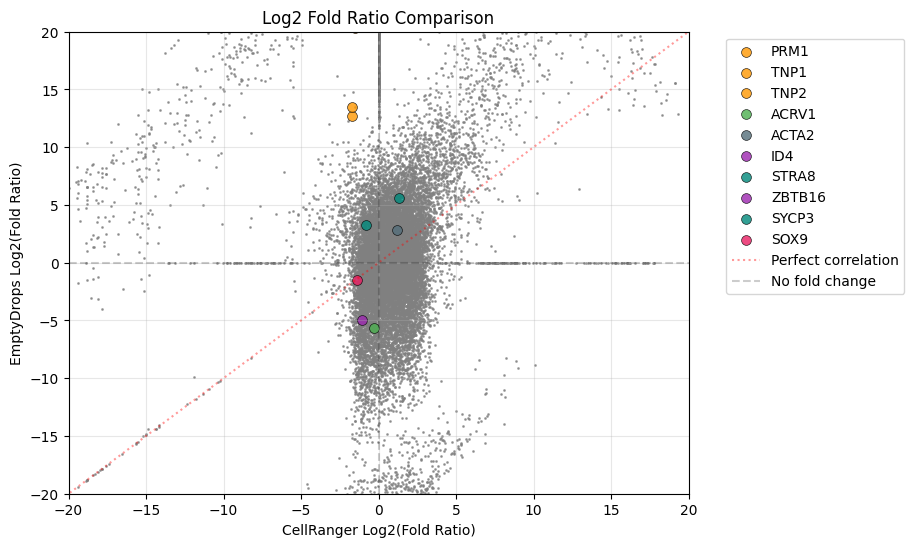

In [59]:
def log2fc_comparison(gene_of_interest_bool=False, zoom=False, CR_fc=CR_fc, ED_fc=ED_fc):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    CR_fc = CR_fc.T.flatten().tolist()[0]
    ED_fc = ED_fc.T.flatten().tolist()[0]

    # Log-scale scatter plot for better visualization
    ax.scatter(np.log2(CR_fc), np.log2(ED_fc), alpha=0.7, s=1, color='gray')


    # Add genes of interest as colored points
    if gene_of_interest_bool: 
        for gene in genes_of_interest:
            if gene in ED_foreground.var_names and gene in CR_foreground.var_names:
                ed_idx = ED_foreground.var_names.get_loc(gene)
                cr_idx = CR_foreground.var_names.get_loc(gene)
                
                ed_ratio = ED_fc[ed_idx]
                cr_ratio = CR_fc[cr_idx]
                gene_color = gene_colors[gene]
                
                ax.scatter(np.log2(cr_ratio), np.log2(ed_ratio), 
                        color=gene_color, s=50, alpha=0.8, edgecolors='black', 
                        linewidth=0.5, label=gene)


    # Add diagonal line
    min_log = min(np.min(np.log2(CR_fc)), np.min(np.log2(ED_fc)))
    max_log = max(np.max(np.log2(CR_fc)), np.max(np.log2(ED_fc)))
    ax.plot([min_log, max_log], [min_log, max_log], 'r:', alpha=0.4, label='Perfect correlation')

    # Add lines at log2(1) = 0 (no fold change)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.2, label='No fold change')
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.2)

    # Apply zoom if specified
    if zoom:
        # Set axis limits to zoom in around the center region
        zoom_range = 20  # Adjust this value to control zoom level
        ax.set_xlim(-zoom_range, zoom_range)
        ax.set_ylim(-zoom_range, zoom_range)

    ax.set_xlabel('CellRanger Log2(Fold Ratio)')
    ax.set_ylabel('EmptyDrops Log2(Fold Ratio)')
    ax.set_title('Log2 Fold Ratio Comparison')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    if gene_of_interest_bool and len(genes_of_interest) > 0:
        df = pd.DataFrame(columns=['gene', 'ED', 'CR', 'log2ED', 'log2CR'])
        for idx, gene in enumerate(genes_of_interest):
            if gene in ED_foreground.var_names and gene in CR_foreground.var_names:
                ed_idx = ED_foreground.var_names.get_loc(gene)
                cr_idx = CR_foreground.var_names.get_loc(gene)
                
                ed_ratio = ED_fc[ed_idx]
                cr_ratio = CR_fc[cr_idx]
            
                # add prints to pandas dataframe
                # print(f"{gene}: ED={ed_ratio:.2f}, CR={cr_ratio:.2f}, Diff={ed_ratio-cr_ratio:.2f}")
                df.loc[idx] = [gene, ed_ratio, cr_ratio, np.log2(ed_ratio), np.log2(cr_ratio)]
                
        print(df)     
    if gene_of_interest_bool:
        if soup:
            fig.savefig("log2fc_ratio_highlight_genes_soup.pdf")
        else:
            fig.savefig("log2fc_ratio_highlight_genes.png")
    else:
        if soup:
            fig.savefig("log2fc_ratio_soup.pdf")
        else:
            fig.savefig("log2fc_ratio.png")

log2fc_comparison()
log2fc_comparison(gene_of_interest_bool=True, zoom=True)

# save plot
if soup:
    fig.savefig("log2fc_comparison_soup.pdf")
else:
    fig.savefig("log2fc_comparison.pdf")


# push to metascape

In [60]:
# convert to panda dataframe with genename, ED_log2fc, CR_log2fc
dfED = pd.DataFrame(columns=['gene', 'foreground', 'background'])

ED_foreground_sum = ED_foreground_norm.sum(axis=0)
ED_background_sum = ED_background_norm.sum(axis=0)
CR_foreground_sum = CR_foreground_norm.sum(axis=0)
CR_background_sum = CR_background_norm.sum(axis=0)

print(ED_foreground_sum)

for idx, gene in enumerate(ED_foreground.var_names):
    dfED.loc[idx] = [gene, ED_foreground_sum[0,idx], ED_background_sum[0,idx]]


dfCR = pd.DataFrame(columns=['gene', 'foreground', 'background'])

for idx, gene in enumerate(CR_foreground.var_names):
    dfCR.loc[idx] = [gene, CR_foreground_sum[0,idx], CR_background_sum[0,idx]]

print(dfED.head())
print(dfCR.head())

print(len(dfED))
print(len(dfCR))

[[  17634.4953036  9463565.29354472  437591.32264125 ...  125783.8305275
   332892.26871651 1316437.53778139]]
      gene    foreground   background
0     A1CF  1.763450e+04  29432144.00
1      A2M  9.463565e+06  22074584.00
2    A2ML1  4.375913e+05   2827773.75
3  A3GALT2  2.140109e+03   4462011.50
4   A4GALT  2.166211e+04  64183556.00
      gene    foreground  background
0  ALDH1A1  38557.527344  29722718.0
1    ANXA1  62941.312500  22262130.0
2     RORB  59326.113281   2971314.5
3    TRPM6  96806.835938   4543526.5
4  C9orf40  92764.648438  64595660.0
22037
22037


In [61]:
# sort df's after fore and background and save top 100 genes
ED_foreground_top100 = (dfED.sort_values(by='foreground', ascending=False)).head(100).drop(columns=['background'])
print("ED_fore:\n", ED_foreground_top100.head())
ED_foreground_top100 = (ED_foreground_top100)['gene'].to_list()

CR_foreground_top100 = (dfCR.sort_values(by='foreground', ascending=False)).head(100).drop(columns=['background'])
print("\nCR_fore:\n", CR_foreground_top100.head())
CR_foreground_top100 = (CR_foreground_top100)['gene'].to_list()


background = (dfED.sort_values(by='background', ascending=False)).drop(columns=['foreground'])
print("\nbackground genes:\n", len(background))
print("\nED_fore genes: ", len(ED_foreground_top100))
print("\nCR_fore genes: ", len(CR_foreground_top100))
ED_CR_background = (background)['gene'].to_list()

ED_fore:
         gene    foreground
16835   PRM1  8.616847e+07
12757  INSL3  6.405856e+07
20465   TNP1  3.310452e+07
2952    COX2  2.131812e+07
2953    COX3  1.855741e+07

CR_fore:
         gene  foreground
11939   PRM1  25529544.0
6201   INSL3  24166338.0
8825    TNP1   9990104.0
10715   DLG2   6372126.0
169    RPLP1   5916056.5

background genes:
 22037

ED_fore genes:  100

CR_fore genes:  100


In [62]:
import os

if soup:
    output_dir = "metascape_gene_lists_soup"
else:
    output_dir = "metascape_gene_lists"
os.makedirs(output_dir, exist_ok=True)

# _BACKGROUND is strict naming scheme for metascape so that it can detect the background automatically

# Export multiple gene lists in Metascape format for comparison
with open(f"{output_dir}/ED_CR_multiple_lists.txt", "w") as f:
    f.write("#ED = EmptyDrops\n")
    f.write("# (1) All lines start with # are ignored;\n")
    f.write("# (2) Two columns: Name and Genes must be tab-separated;\n")
    f.write("# (3) Gene identifiers are concatenated within the second column by space/comma/semicolon, space/comma/semicolon must not be part of the gene identifier.\n")
    if soup:
        f.write(f"pyED_FORE_SOUP\t{','.join(ED_foreground_top100)}\n")
    else:
        f.write(f"pyED_FORE\t{','.join(ED_foreground_top100)}\n")
    f.write(f"CR_FORE\t{','.join(CR_foreground_top100)}\n")
    f.write(f"_BACKGROUND\t{','.join(ED_CR_background)}")


print(f"Gene lists exported to {output_dir}/ directory")


Gene lists exported to metascape_gene_lists_soup/ directory


## metascape thoughts
metascape only generates heatmaps when there are more than 1 foreground. since my foreground varies and the background is calculated for each method individually out of the foreground we cant just use the same background and put both method.

So inserted the same background for both foregrounds to generate the heatmap showcase the different pvalues per pathway.

NO the _BACKGROUND needs to have all genes of the raw file, so inserting all 22000 genes ! metascape is automatically filtering the intersection out. 